# Loading libraries and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv('train.csv').sample(frac=0.1, replace=True, random_state=2)
data = data.reset_index(drop=True)


# Data characteristics

In [4]:
print("Shape: ", data.shape)
data.head()

Shape:  (30000, 25)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,100879,0,0,1,T,Y,Green,Circle,Lion,Russia,...,e1b66f5f2,1,Novice,Boiling Hot,c,B,ri,1,3,0
1,203245,0,0,0,F,Y,Blue,Trapezoid,Cat,Finland,...,506b8e5dd,1,Expert,Freezing,j,I,ZS,1,3,0
2,95816,0,0,1,F,Y,Blue,Square,Snake,India,...,602bcc56f,1,Novice,Freezing,g,F,tM,1,4,1
3,84434,0,0,0,T,N,Green,Triangle,Dog,China,...,97616a1ac,1,Grandmaster,Cold,l,Z,Uu,1,2,1
4,33867,0,0,0,F,Y,Red,Trapezoid,Snake,Russia,...,34058a17c,3,Master,Hot,a,Q,CM,4,1,0


In [5]:
def see_column(name):
    print("Unique values:", data[name].nunique())
    print("They are: ", data[name].unique())
    print(data[name].head())
    
see_column("ord_4")

Unique values: 26
They are:  ['B' 'I' 'F' 'Z' 'Q' 'U' 'X' 'G' 'E' 'A' 'S' 'P' 'D' 'J' 'W' 'R' 'K' 'H'
 'O' 'L' 'V' 'Y' 'T' 'M' 'C' 'N']
0    B
1    I
2    F
3    Z
4    Q
Name: ord_4, dtype: object


In [218]:
data.nunique()

id        28536
bin_0         2
bin_1         2
bin_2         2
bin_3         2
bin_4         2
nom_0         3
nom_1         6
nom_2         6
nom_3         6
nom_4         4
nom_5       222
nom_6       519
nom_7      1199
nom_8      2143
nom_9      9629
ord_0         3
ord_1         5
ord_2         6
ord_3        15
ord_4        26
ord_5       192
day           7
month        12
target        2
dtype: int64

In [49]:
data.dtypes

id         int64
bin_0      int64
bin_1      int64
bin_2      int64
bin_3     object
bin_4     object
nom_0     object
nom_1     object
nom_2     object
nom_3     object
nom_4     object
nom_5     object
nom_6     object
nom_7     object
nom_8     object
nom_9     object
ord_0      int64
ord_1     object
ord_2     object
ord_3     object
ord_4     object
ord_5     object
day        int64
month      int64
target     int64
dtype: object

# Data preprocessing and cleaning

In [6]:
#columns that we can use directly
ready_columns = ['bin_0', 'bin_1', 'bin_2']

#categorical columns with string data
str_categorical_columns = ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'] 

#ordinal columns
int_ordinal_columns = ['ord_0']
str_ordinal_columns = ['ord_1', 'ord_2', 'ord_3', 'ord_4']



#categorical columns with integer data
int_categorical_columns = ['day', 'month']

#columns wiht integer alues
real_columns = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

#column ord_5 is processed alone.

YY = data['target']

Creating a new dataframe for ML

In [8]:
#function to process the data
import string

def make_good_data_frame(in_data, n_pca = 0):
    
    lst_df = []
    
    #ready dataframe RD
    temp = in_data[ready_columns].copy()
    lst_df.append(temp)
    
    
    #String categorical dataframe SCD
    temp = pd.get_dummies(in_data[str_categorical_columns], drop_first=True)
    lst_df.append(temp)
    
    
    #ordinal columns
    lst_df.append(in_data['ord_0'])
    mapping = {"ord_1": {'Grandmaster':4, 'Expert':2, 'Novice':0, 'Contributor':1, 'Master':3},
               "ord_2": {'Cold':1, 'Hot':3, 'Lava Hot':5, 'Boiling Hot':4, 'Freezing':0, 'Warm':2},
               "ord_3": {'a':1, 'c':3, 'j':10, 'g':7, 'l':12, 'i':9, 'h':8, 'o':15, 'k':11, 'd':4, 'e':5, 'b':2, 'f':6, 'n':14, 'm':13},
               "ord_4": {'B':2, 'I':9, 'F':6, 'Z':26, 'Q':17, 'U':21, 'X':24, 'G':7, 'E':5, 'A':1, 'S':19, 'P':16, 'D':4, 'J':10, 'W':23, 'R':18, 'K':11, 'H':8,
                        'O':15, 'L':12, 'V':22, 'Y':25, 'T':20, 'M':13, 'C':3, 'N':14}}
    temp = in_data[str_ordinal_columns].replace(mapping).copy()
    lst_df.append(temp)
    
    
    #Integer categorical dataframe ICD
    temp = pd.DataFrame(index = in_data.index)
    for name in int_categorical_columns:
        tt = pd.get_dummies(in_data[name], drop_first=True)
        temp = pd.merge(temp, tt, left_index=True, right_index=True)
    #lst_df.append(temp)
    
    
    #real columns
    temp = pd.DataFrame(index = in_data.index)
    for c in real_columns:
        temp[c] = in_data[c].apply(lambda x : int(x, 16))
    #lst_df.append(temp)
    
    
    #ord_5
    temp = in_data['ord_5'].apply(lambda x : string.ascii_letters.index(x[0])*52 + string.ascii_letters.index(x[1])).copy()
    #lst_df.append(temp)
    
    
    
    #mergin all the dataframes
    result = pd.DataFrame(index = in_data.index)
    for x in lst_df:
        result = pd.merge(result, x, left_index=True, right_index=True)
    
    #normalization
    result = ((result - result.min())/(result.max() - result.min()) - 0.5)*2.0
    
    #PCA
    if n_pca == 0:
        return result
    
    pca = PCA(n_components=n_pca)
    principalComponents = pca.fit_transform(result)
    result = pd.DataFrame(principalComponents)
    
    return result
   

XX = make_good_data_frame(data, 5)
XX.head()

,0,1,2,3,4
0,-1.267256,-1.285932,1.474857,1.049759,0.798295
1,0.410818,1.347219,-1.547602,0.329300,-0.698375
2,0.208769,-1.428566,-0.539218,-1.409446,0.240299
3,-1.205092,1.460951,-0.338159,-1.083494,-0.816539
4,1.645399,-0.319260,-1.276986,1.191555,1.113300


In [255]:
def see_column(name):
    print("Unique values:", XX[name].nunique())
    print("They are: ", XX[name].unique())
    print(XX[name].head())
    
see_column("ord_5")

Unique values: 192
They are:  [-0.33927246  1.         -0.23979213  0.7891611   0.10764662 -0.56867112
 -0.35337788 -0.34743875 -0.09576837  0.66740906  0.0081663   0.8671121
 -0.77876763  0.05048255 -0.49443207 -0.36451373 -0.55382331  0.42613215
 -0.17297699  0.10690423  0.68893838 -0.61247216  0.61247216 -0.82331106
  0.35115071 -0.74164811  0.91536748 -0.88047513 -0.95991091 -0.97327394
  0.39198218 -0.85671863  0.11952487  0.97921307 -0.29175947  0.22048998
  0.63028953  0.6481069  -0.04602821 -0.90497402 -0.45137342 -0.45879733
  0.04305865  0.6250928   0.25538233 -0.40905716  0.2345954  -0.52932442
 -0.19673348  0.48626578  0.44914625  0.11358575  0.27913883 -0.59317001
 -0.13734224 -0.83964365 -0.85523385 -0.00222717  0.55605048 -0.97847068
 -0.35708983  0.89532294 -0.57980698  0.5389755   0.7735709   0.51150705
  0.25092799  0.85300668 -0.1640683  -0.97104677  0.40014848 -0.72605791
 -0.69784707 -0.80326652 -0.21529324  0.49517446  0.19747587  0.80400891
 -0.37342242  0.767631

# Clusterings

In [9]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=0).fit(XX)

In [252]:
kmeans.labels_

array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

In [10]:
goods=0
for x,y in zip(kmeans.labels_, data['target']):
    if x == y:
        goods += 1
result = goods/len(data)

if result < 0.5:
    print(1-result)
else:
    print(result)

0.5537666666666667


In [209]:
kmeans.cluster_centers_

array([[-1.22199341,  0.05095275, -0.02385086,  0.02467001, -0.00392842,
        -0.01538097,  0.0062057 ,  0.03759604, -0.00930818,  0.00411062],
       [ 0.89609085, -0.03736378,  0.0174899 , -0.01809058,  0.00288072,
         0.0112789 , -0.00455065, -0.02756927,  0.00682571, -0.00301433]])

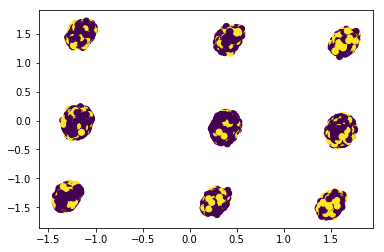

In [11]:
plt.scatter(XX[0], XX[1], c = data['target'])

In [12]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1.0, min_samples=10).fit(XX)
db.labels_

array([ 0,  1,  2, ..., 36, 11, 12])

In [13]:
goods=0
for x,y in zip(db.labels_, data['target']):
    if x == y:
        goods += 1
result = goods/len(data)

print(result)

0.020233333333333332
